## Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pickle
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
import scipy
from textblob import TextBlob
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

train.csv shape is  (139753, 9)
test.csv shape is  (17470, 2)


## Feature Extraction

In [6]:
def process(df):
    # This is where you can do all your processing
    
    df['HelpfulnessRatio'] = np.where(df['HelpfulnessDenominator'] > 0,
                             df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
    
    df['NotHelpful'] = df['HelpfulnessDenominator'] - df['HelpfulnessNumerator']
    
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['Day'] = df['Time'].dt.day
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    
    df['Text'].fillna('', inplace=True)
    df['Summary'].fillna('', inplace=True)
    df["Review"] = df["Summary"] + " " + df["Text"]
    df['Review'].fillna('', inplace=True)
    df['ReviewLength'] = df.apply(lambda row : len(row['Review'].split()) if type(row['Review']) == str else 0, axis = 1)
    
    df['ReviewPolarity'] = df['Review'].apply(lambda text: TextBlob(text).sentiment.polarity)
    df['ReviewSubjectivity'] = df['Review'].apply(lambda text: TextBlob(text).sentiment.subjectivity)
    
    df['NumExclamation'] = df['Review'].str.count('!')
    df['NumCaps'] = df['Review'].str.findall(r'[A-Z]').str.len()
    df['CapsRatio'] = df['NumCaps'] / df['ReviewLength']
    df['ExclamationRatio'] = df['NumExclamation'] / df['ReviewLength']
     
    good_words_full = ['great', 'like', 'good', 'love', 'best', 'really', 'enjoyed', 'fantastic', 'amazing', 'excellent', 'wonderful']
    df['GoodWordsRatio'] = df['Review'].apply(lambda review: sum(review.lower().count(word) for word in good_words_full) / len(review.split()) if len(review.split()) > 0 else 0)
    
    bad_words_full = ['even', 'bad', 'worst', 'awful', 'terrible', 'horrible', 'disappointing', 'disappointed', 'poor', 'hate', 'dont', "don't"]
    df['BadWordsRatio'] = df['Review'].apply(lambda review: sum(review.lower().count(word) for word in bad_words_full) / len(review.split()) if len(review.split()) > 0 else 0)
    
    
    def clean_and_split_text(text):
        # Remove any punctuation and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Convert text to lowercase and split into words
        words = text.lower().split()
        return words

    bad_words_set = ['even', 'bad', 'worst', 'awful', 'terrible', 'horrible', 'disappointing', 'disappointed', 'poor', 'hate', 'dont', "don't"]
    good_words_set = ['great', 'like', 'good', 'love', 'best', 'really', 'enjoyed', 'fantastic', 'amazing', 'excellent', 'wonderful']
    
    df['BadWordsNum'] = df['Review'].apply(
        lambda review: sum(1 for word in clean_and_split_text(review) if word in bad_words_set)
    )

    df['GoodWordsNum'] = df['Review'].apply(
        lambda review: sum(1 for word in clean_and_split_text(review) if word in good_words_set)
    )
    
    total_word_count = df['ReviewLength'].sum()
    total_negative_word_count = sum(df['BadWordsNum'])
    average_negative_word_usage = total_negative_word_count / total_word_count
    df['NegativeWordUsageDeviation'] = (
        df['BadWordsNum'] / df['ReviewLength']
    ) - average_negative_word_usage
    
    nltk.download('vader_lexicon')
    sid = SentimentIntensityAnalyzer()
    df['PositiveScore'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['pos'])
    df['NegativeScore'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['neg'])
    df['NeutralScore'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['neu'])
    df['CompoundScore'] = df['Review'].apply(lambda x: sid.polarity_scores(x)['compound'])
    
    
    df = df.drop(columns=['Summary', 'Text', 'DayOfWeek', 'Day', 'Time'])
    correlations = df.drop(columns=['Review', 'ProductId', 'UserId']).corr()['Score'].sort_values(ascending=False)
    print(correlations)
    
    return df



In [7]:
# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

In [8]:
# Process the DataFrame
train_processed = process(trainingSet)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/doruk/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Score                         1.000000
ReviewPolarity                0.466230
CompoundScore                 0.397847
PositiveScore                 0.354221
GoodWordsRatio                0.227267
ReviewSubjectivity            0.094793
Year                          0.088850
ExclamationRatio              0.084457
NumExclamation                0.047487
CapsRatio                     0.041387
GoodWordsNum                  0.041023
Month                        -0.009580
HelpfulnessNumerator         -0.011531
NumCaps                      -0.025855
Id                           -0.051049
ReviewLength                 -0.078221
HelpfulnessDenominator       -0.092002
HelpfulnessRatio             -0.109879
NeutralScore                 -0.138258
BadWordsNum                  -0.272797
NegativeWordUsageDeviation   -0.283034
NotHelpful                   -0.288221
BadWordsRatio                -0.290445
NegativeScore                -0.402475
Name: Score, dtype: float64


In [24]:
train_processed = train_processed.drop(columns=['Month'])

In [25]:
# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]
trainX = trainX.dropna()

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

## Creating your model

In [26]:
# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

In [27]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=42
    )

# This is where you can do more feature selection
X_train = X_train.drop(columns=['Id'])
X_test = X_test.drop(columns=['Id'])

In [28]:
# Fit the StandardScaler on the numerical columns of the training data
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])
# Transform the training data
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
# Transform the test data with the fitted scaler
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])


In [29]:
tfidf_transformer = TfidfVectorizer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train['Review'])
# Transform the test data with the fitted transformer
X_test_tfidf = tfidf_transformer.transform(X_test['Review'])

In [30]:
# Fit OneHotEncoder on the training data
OHE = OneHotEncoder(sparse=True, handle_unknown='ignore')
ID_fitter = OHE.fit(X_train[['ProductId', 'UserId']])
# Transform both training and test data with the fitted encoder
Train_IDs = ID_fitter.transform(X_train[['ProductId', 'UserId']])
Test_IDs = ID_fitter.transform(X_test[['ProductId', 'UserId']])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
X_train = X_train.drop(['ProductId','UserId'], axis=1)
X_test = X_test.drop(['ProductId','UserId'], axis=1)

X_train = X_train.drop(columns=['Review'])
X_test = X_test.drop(columns=['Review'])

In [46]:
X_train_final = hstack([X_train, Train_IDs, X_train_tfidf])

In [47]:
X_test_final = hstack([X_test, Test_IDs, X_test_tfidf])

In [52]:
# Define the parameter grid
param_grid = {
    'alpha': [1.0, 4.0, 5.0, 10.0]  # You can expand this grid as needed
}

# Initialize the Ridge model
ridge = Ridge()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, verbose=1)

# Perform the grid search
grid_search.fit(X_train_final, Y_train)

# Retrieve the best parameters
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha parameter: {best_alpha}")

# Fit the Ridge model using the best alpha parameter
ridge_optimized = Ridge(alpha=best_alpha).fit(X_train_final, Y_train)


Y_test_predictions = ridge_optimized.predict(X_test_final).clip(1, 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best alpha parameter: 4.0


In [53]:
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions))

RMSE on testing set =  0.5960250612885891


In [54]:
print("Accuracy on testing set =", accuracy_score(Y_test, np.round(Y_test_predictions)))

Accuracy on testing set = 0.5372411762781721


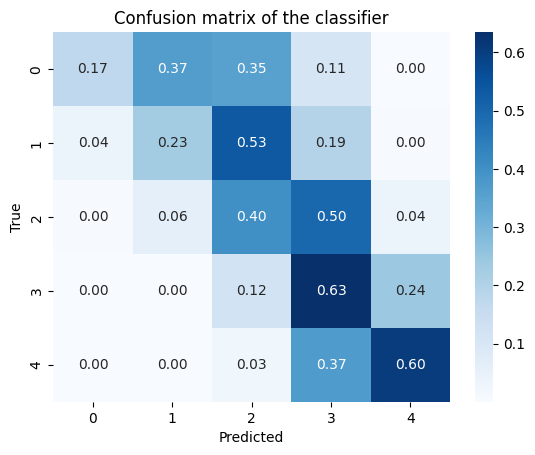

In [55]:
cm = confusion_matrix(Y_test, np.round(Y_test_predictions), normalize='true')
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [56]:
# Load the Kaggle test set
X_submission = pd.read_csv("./data/X_test.csv")
X_submission.columns

Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'HelpfulnessRatio', 'NotHelpful', 'Year',
       'Review', 'ReviewLength', 'ReviewPolarity', 'ReviewSubjectivity',
       'NumExclamation', 'NumCaps', 'CapsRatio', 'ExclamationRatio',
       'GoodWordsRatio', 'BadWordsRatio', 'BadWordsNum', 'GoodWordsNum',
       'NegativeWordUsageDeviation', 'PositiveScore', 'NegativeScore',
       'NeutralScore', 'CompoundScore', 'Score'],
      dtype='object')

In [57]:
# Drop 'Id' and 'Score' for scaling numerical features
X_submission_processed = X_submission.drop(columns=['Id', 'Score'])

# Separate out the numerical columns
numerical_columns_submission = X_submission_processed.select_dtypes(include=['int64', 'float64']).columns

# Scale the numerical features using the already fitted scaler
X_submission_processed[numerical_columns_submission] = scaler.transform(X_submission_processed[numerical_columns_submission])

# Transform the test reviews using the already fitted TF-IDF vectorizer
X_submission_tfidf = tfidf_transformer.transform(X_submission_processed['Review'])

# Transform 'ProductId' and 'UserId' using the already fitted OneHotEncoder
X_submission_OHE = ID_fitter.transform(X_submission_processed[['ProductId', 'UserId']])

# Drop 'ProductId', 'UserId', and 'Review' columns before stacking
X_submission_processed = X_submission_processed.drop(columns=['ProductId', 'UserId', 'Review'])

# Stack all features together: numerical, OneHotEncoded, and TF-IDF vectorized
X_submission_final = hstack([X_submission_processed, X_submission_OHE, X_submission_tfidf])

# Make predictions using the optimized Ridge model
X_submission['Score'] = ridge_optimized.predict(X_submission_final).clip(1, 5)

submission = X_submission[['Id', 'Score']]
# Save the submission file
submission.to_csv("./data/submission.csv", index=False)

#### Now you can upload the `submission.csv` to kaggle